### Predicting Market crashes with topology in python
#### Beyond Traditional Indicators for Isights Into Market Behavior
https://medium.com/@crisvelasquez/predicting-stock-market-crashes-with-topological-data-analysis-in-python-1dc4f18ca7ca

[PH(D) = {[b,d]| b is birth time, d is death time of a feature in data D}]

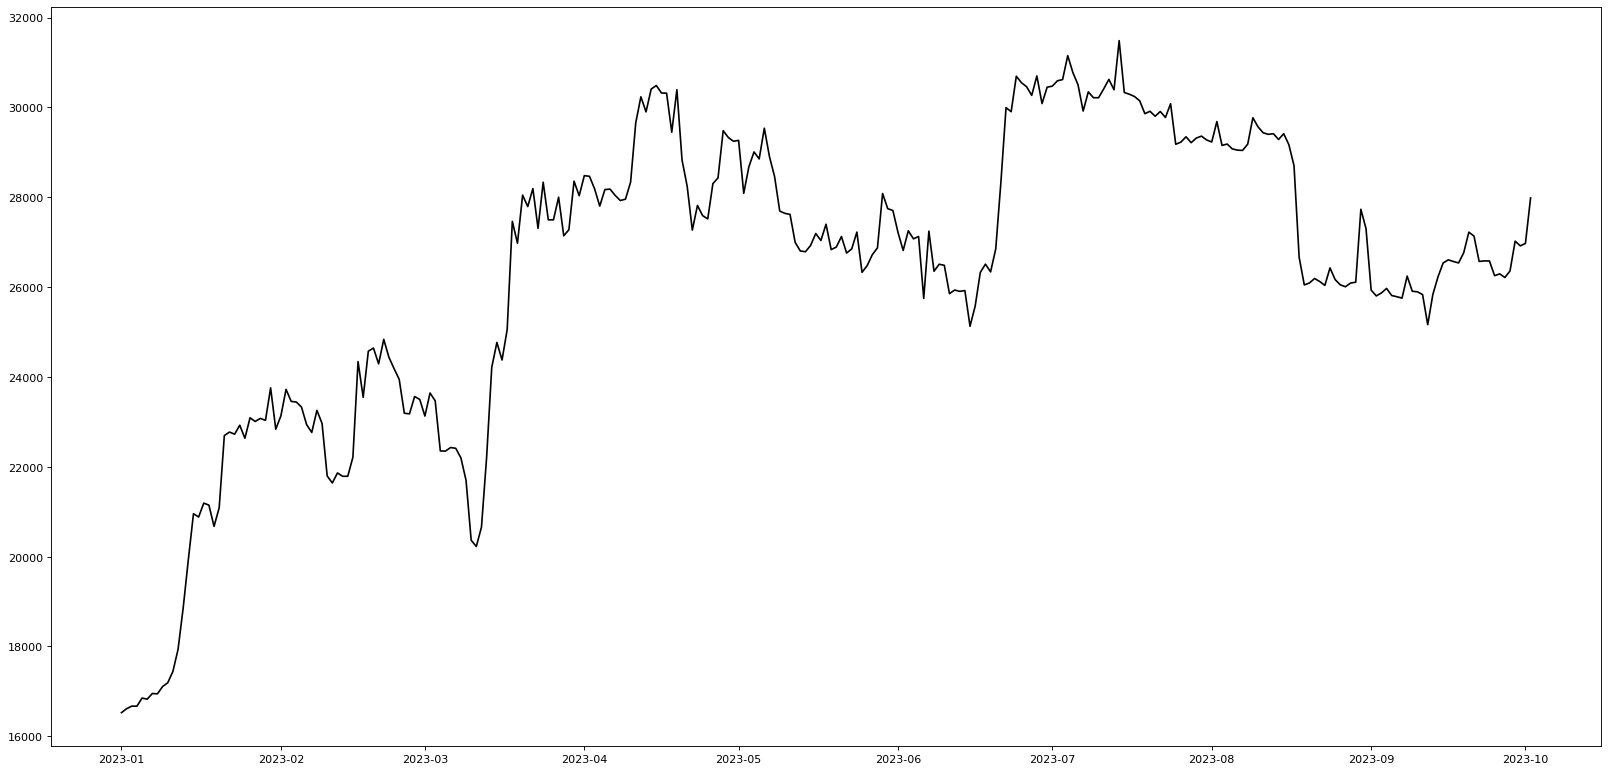

In [3]:
%matplotlib inline

import numpy as np 
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
from matplotlib import style
import matplotlib.colors as mcolors
import yfinance as yf
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")


# binance api 
import nasdaqdatalink
import quandl

quandl.ApiConfig.api_key = "AAHgDbrpouZ8KXGz3ihH"

#quandl.get("USTREASURY/REALYIELD")

start_date_INPUT = "2023-01-01"

BTC_recent = quandl.get("BCHAIN/MKPRU", start_date=start_date_INPUT)

price_x = BTC_recent.index 
prices = BTC_recent["Value"].values

plt.subplots(1, 1, figsize=(25, 12), dpi=80)
plt.plot(price_x, prices, color='k')

log_returns = np.log(prices[1:]/prices[:-1])

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


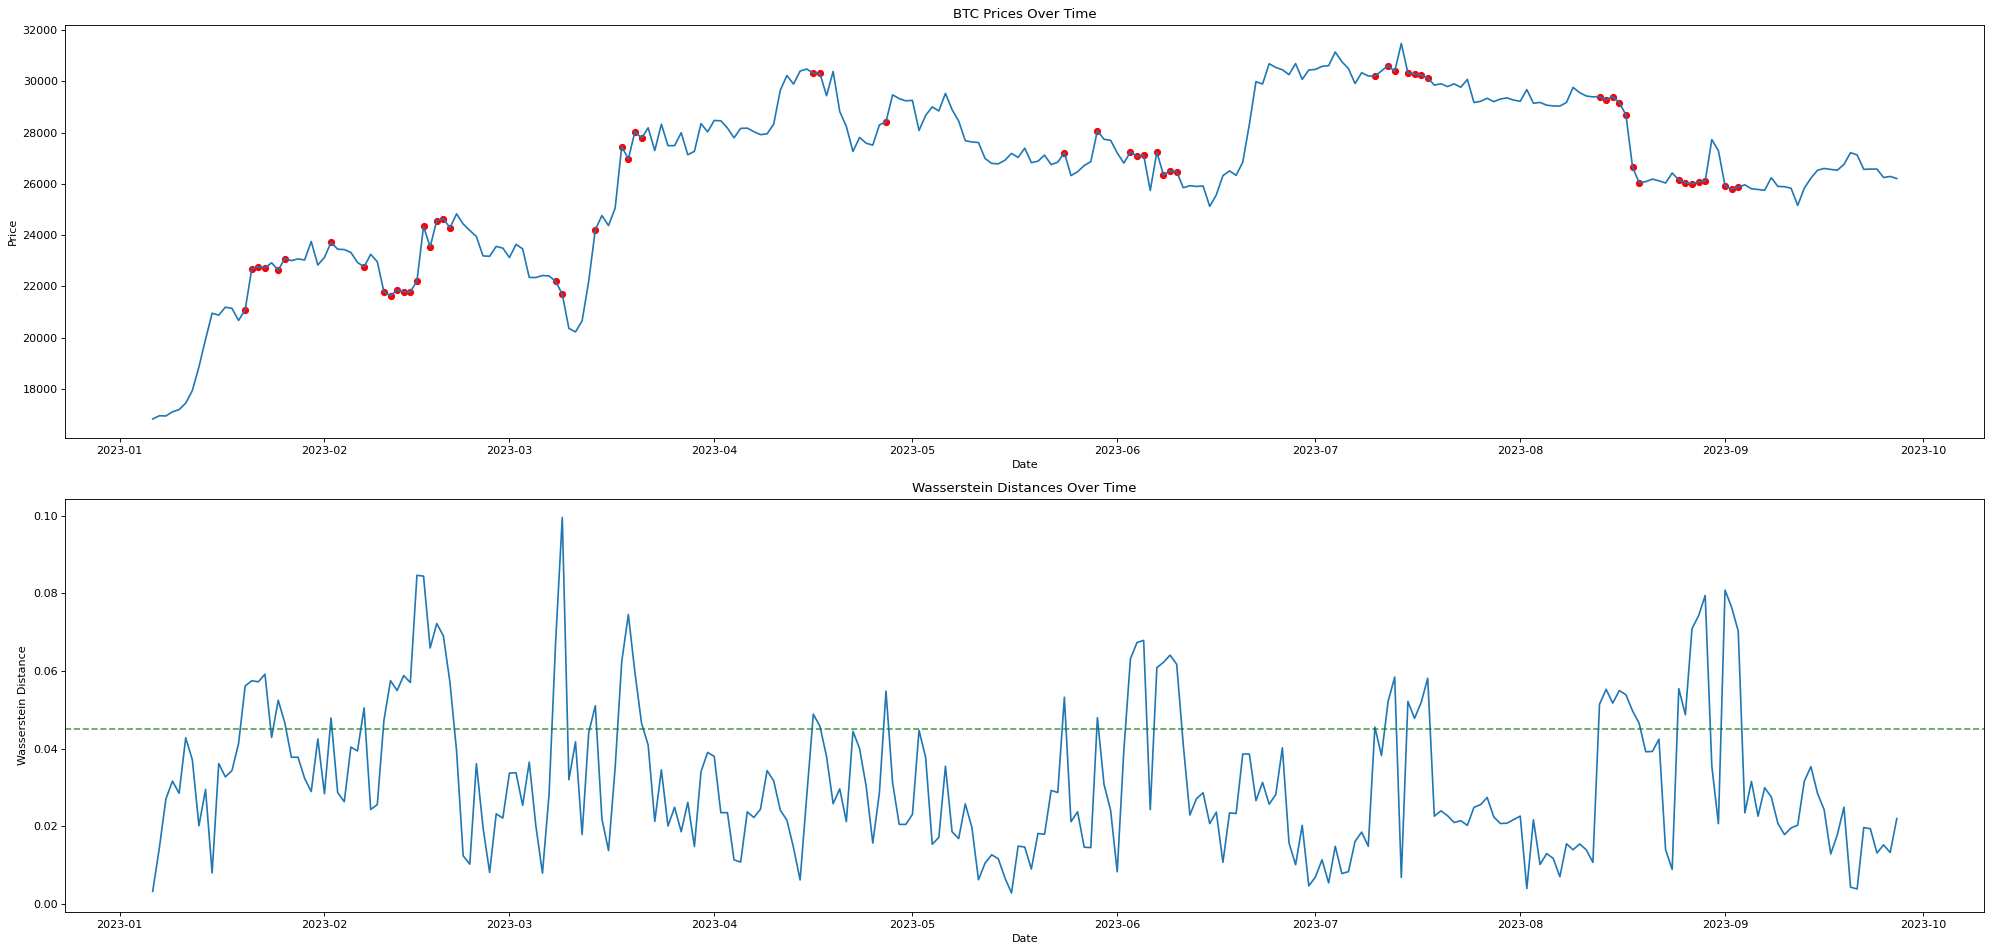

In [7]:
from ripser import Rips
import persim
rips = Rips()


window_size = 5
threshold = 0.045

n = len(log_returns) - (2 * window_size) + 1
distances = np.full((n, 1), np.nan)  # Using np.full with NaN values

for i in range(n):
    segment1 = log_returns[i:i+window_size].reshape(-1, 1)
    segment2 = log_returns[i+window_size:i+(2*window_size)].reshape(-1, 1)

    if segment1.shape[0] != window_size or segment2.shape[0] != window_size:
        continue

    dgm1 = rips.fit_transform(segment1)
    dgm2 = rips.fit_transform(segment2)
    distance = persim.wasserstein(dgm1[0], dgm2[0], matching=False)
    distances[i] = distance

dates = price_x[window_size:-window_size]




valid_indices = ~np.isnan(distances)
valid_dates = dates[valid_indices.flatten()]
valid_distances = distances[valid_indices]

alert_indices = [i for i, d in enumerate(valid_distances) if d > threshold]
alert_dates = [valid_dates[i] for i in alert_indices]
alert_values = [BTC_recent["Value"].iloc[i + window_size] for i in alert_indices]

fig, ax = plt.subplots(2, 1, figsize=(25, 12), dpi=80)
    
ax[0].plot(valid_dates, BTC_recent["Value"].iloc[window_size:-window_size])
ax[0].scatter(alert_dates, alert_values, color='r', s=30)
ax[0].set_title('BTC Prices Over Time')
ax[0].set_ylabel('Price')
ax[0].set_xlabel('Date')
    
ax[1].plot(valid_dates, valid_distances)
ax[1].set_title('Wasserstein Distances Over Time')
ax[1].set_ylabel('Wasserstein Distance')
ax[1].axhline(threshold, color='g', linestyle='--', alpha=0.7)
ax[1].set_xlabel('Date')

plt.tight_layout()
plt.show()
